In [1]:
import numpy as np # For array operations
import matplotlib.pyplot as plt
import cv2 as cv # Mostly for showing and normalization
import os #To iterate through directories and join paths
from sklearn import preprocessing
from random import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from random import randint
import h5py
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Check if a GPU is available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-09-25 16:14:11.821250: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 16:14:12.110944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 16:14:14.291940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## DenseNet

In [9]:
WIDTH = 384
HEIGHT = 384

IMAGE_SIZE = (WIDTH, HEIGHT)
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', weights=True)
model.to(device)  # Move the model to the GPU if available
model.eval()

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input data
])

train_dataset = datasets.ImageFolder('/cluster/home/ammaa/Downloads/Ammars/Models/PIM/FGVC-Multi/Split_500/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 100
best_accuracy = 0.0
best_model_path = './best_dense_201.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = 100.0 * correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), best_model_path)

Using cache found in /cluster/home/ammaa/.cache/torch/hub/pytorch_vision_v0.10.0


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 39.44 GiB total capacity; 37.57 GiB already allocated; 2.12 MiB free; 37.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Check if a GPU is available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation for the testing dataset (should match the one used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match DenseNet's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input data
])

# Load the testing dataset and move it to the GPU
test_dataset = datasets.ImageFolder('/cluster/home/ammaa/Downloads/Ammars/Models/PIM/FGVC-Multi/wrist_data/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load your previously trained model, move it to the GPU, and set it to evaluation mode
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', weights=False)  # Replace with your model architecture
model.load_state_dict(torch.load('./best_dense_201.pth'))  # Replace with the path to your trained model
model.to(device)
model.eval()

Using cache found in /cluster/home/ammaa/.cache/torch/hub/pytorch_vision_v0.10.0
/cluster/home/ammaa/.conda/envs/ammars/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

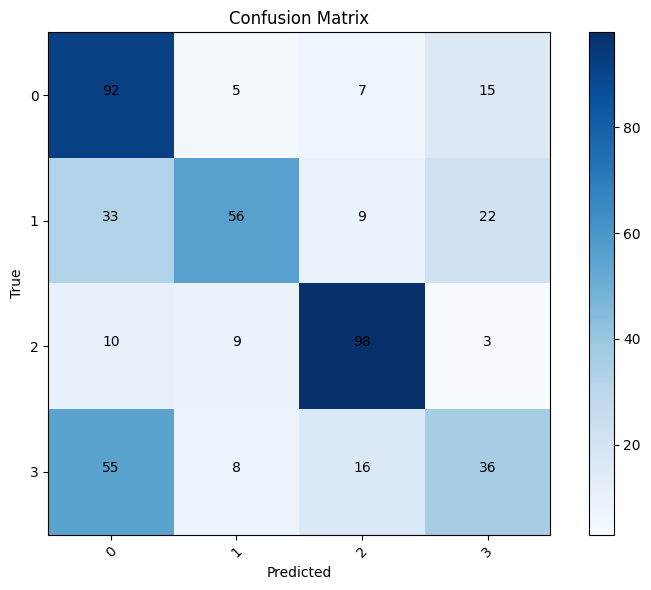

In [5]:
# Initialize variables to store predicted labels and true labels
all_preds = []
all_labels = []

# Use the model to predict labels for the testing dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix with numerical values in cells
class_names = test_dataset.classes
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add numerical values within each cell
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment="center", color="black")

plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Compute the confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(conf_mat)

# Now, compute precision, recall, f1-score and support
precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_preds)

# These are now arrays of length 4, with one value per class
for i in range(4):
    print(f"Class {i} - Precision: {precision[i]:.4f}")
    print(f"Class {i} - Recall: {recall[i]:.4f}")
    print(f"Class {i} - F1 Score: {f1_score[i]:.4f}")
    print(f"Class {i} - Support: {support[i]}")

# Overall accuracy

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Check unique values
unique_labels = np.unique(all_labels)
unique_preds = np.unique(all_preds)
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")


Confusion Matrix:
[[92  5  7 15]
 [33 56  9 22]
 [10  9 98  3]
 [55  8 16 36]]
Class 0 - Precision: 0.4842
Class 0 - Recall: 0.7731
Class 0 - F1 Score: 0.5955
Class 0 - Support: 119
Class 1 - Precision: 0.7179
Class 1 - Recall: 0.4667
Class 1 - F1 Score: 0.5657
Class 1 - Support: 120
Class 2 - Precision: 0.7538
Class 2 - Recall: 0.8167
Class 2 - F1 Score: 0.7840
Class 2 - Support: 120
Class 3 - Precision: 0.4737
Class 3 - Recall: 0.3130
Class 3 - F1 Score: 0.3770
Class 3 - Support: 115
Accuracy: 0.5949
